In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sns.set_context('talk')

In [74]:
ROOT_DIR = '/analysis/gh-msun/'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
PROJECT_DIR = ROOT_DIR + f'projects/{PROJECT_SLUG}/'
EXPERIMENT = 'primary_immune_loyfer'
EXPERIMENT_DIR = PROJECT_DIR + f'output/experiment/{EXPERIMENT}/'
BACKGROUND = 'wholeblood'

#---Load all custom scripts---#
SCRIPT_DIR = PROJECT_DIR + 'scripts/'
sys.path.append(SCRIPT_DIR)

import create_mixture as cm
import score_matrix as sm
import deconvolution as dcnv
import helper as hlpr

#---Load atlas---#
ATLAS_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.tsplit.atlas.tsv.gz'
REGION_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.tsplit.region_to_ref_celltype.tsv.gz'

atlas = pd.read_csv(ATLAS_PATH, sep='\t',index_col=None)
atlas = atlas.set_index('region_id')
atlas.columns.name = 'ref_celltype'
atlas.shape

ref_region_df = pd.read_csv(REGION_PATH, sep='\t')
ref_region_df['ref_celltype'][ref_region_df['ref_celltype'] == 'immune_cd4_t'] = 'immune_cd4'
ref_region_df['ref_celltype'][ref_region_df['ref_celltype'] == 'immune_cd8_t'] = 'immune_cd8'

atlas = atlas.loc[ref_region_df['region_id'], :].copy()
atlas.shape

(285, 10)

In [75]:
%%time

# load score data from all cell types
deconvolution_nnls = []
deconvolution_naive = []
CELLTYPES = ['Blood-B', 'Blood-CD4', 'Blood-CD8', 'Blood-Mono+Macro', 'Blood-NK', 'Blood-Granul']

TITRATION_LIST = [0.2, 0.15, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.006, 0.004, 0.002, 0.001, 0]
SCORE_VAR = 'frac_alpha_leq_25pct'
FILTER_COV = 20

for celltype in CELLTYPES: 
    EXPERIMENT_NAME = f'{celltype}-{BACKGROUND}/'            # <-- iterate over this
    EXPERIMENT_CELLTYPE_DIR = EXPERIMENT_DIR + f'{EXPERIMENT_NAME}/'
    SCORE_DIR = EXPERIMENT_CELLTYPE_DIR + 'methyl_score/'

    # iterate nnls deconvolition on each score_df
    deconv_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)
    
     # iterate naive deconvolution on each score_df
    deconv_naive = dcnv.compute_deconvolution_from_methyl_score_dir_naive(path_to_methyl_score_dir=SCORE_DIR, 
                                                                             filter_cov=FILTER_COV, 
                                                                             score_var=SCORE_VAR, 
                                                                             ref_region_df=ref_region_df)
    
    deconvolution_nnls.append(deconv_nnls)
    deconvolution_naive.append(deconv_naive)
    

CPU times: user 27 s, sys: 77.7 ms, total: 27.1 s
Wall time: 27.1 s


In [76]:
def boxplot_titration(list_of_deconvolution_dfs, cell_type, true_proportions, deconvolution_method_name):

    dfs = []

    for i in range(0, len(list_of_deconvolution_dfs)):
        df = list_of_deconvolution_dfs[i]
        phat = df[df.index == cell_type].values.squeeze()
        p_idx = np.repeat(true_proportions[i], len(phat))
        df = {'idx': p_idx, 'phat': phat}
        df = pd.DataFrame(df)
        df['idx'] = df['idx'].astype(str)
        dfs.append(df)

    df = pd.concat(dfs)
    
    plt.figure(figsize=(10, 8))  # width and height in inches

  #   sns.boxplot(x='idx', y='phat', data=df)
    sns.violinplot(x='idx', y='phat', data=df)

    plt.title(f'Titration Boxplots ({deconvolution_method_name})')
    plt.xlabel(f'True proportion of {cell_type}')
    plt.ylabel(f'Estimated proportion ({deconvolution_method_name})')
    plt.grid(True, alpha=0.5)
    plt.gca().set_axisbelow(True)
    
    plt.xticks(range(len(true_proportions)), true_proportions, rotation='vertical')
    
    plt.show()

In [77]:
# # for t cell
# WHOLE_BLOOD_ABUNDANCE = {'Blueprint-B':0.06,
#                          'Blueprint-Mono':0.09,
#                          'Blueprint-Neutro':0.57,
#                          'Blueprint-CD4':0.16,
#                          'Blueprint-CD8':0.07,
#                          'Blueprint-NK':0.05}

# PROPORTIONS = hlpr.generate_custom_background_proportions(titration_list=TITRATION_LIST, 
#                                                           custom_proportion=WHOLE_BLOOD_ABUNDANCE, 
#                                                           list_of_celltypes=CELLTYPES, 
#                                                           titrating_celltype='Blueprint-CD4')

# actual_t_props = list()
# for prop in PROPORTIONS:
#     actual_t_props.append(round(prop[0] + prop[1], 3))
# actual_t_props

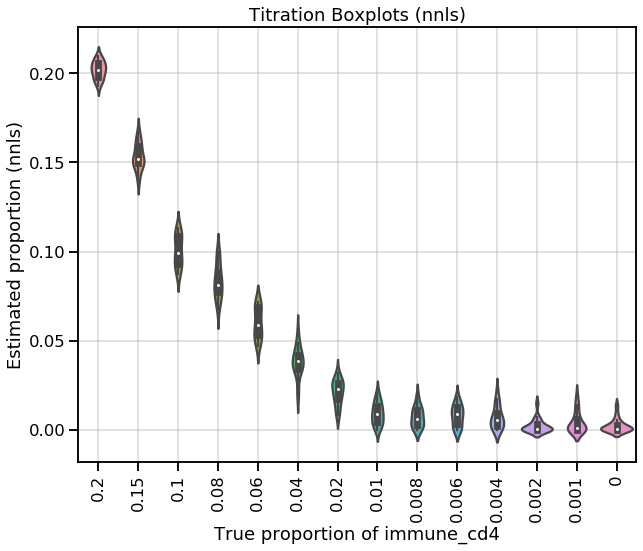

In [78]:
TITRATION_LIST = [0.2, 0.15, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.006, 0.004, 0.002, 0.001, 0]
# TITRATION_LIST = actual_t_props
CELLTYPE_ATLAS = ['immune_b', 'immune_cd4', 'immune_cd8', 'immune_dend_plus_macro_plus_mono', 'immune_nk', 'immune_neutro']
cell_idx = 1
boxplot_titration(deconvolution_nnls[cell_idx], CELLTYPE_ATLAS[cell_idx], TITRATION_LIST , 'nnls')

In [79]:
len(deconvolution_naive[1])

14

In [80]:
len(deconvolution_nnls[1])

14

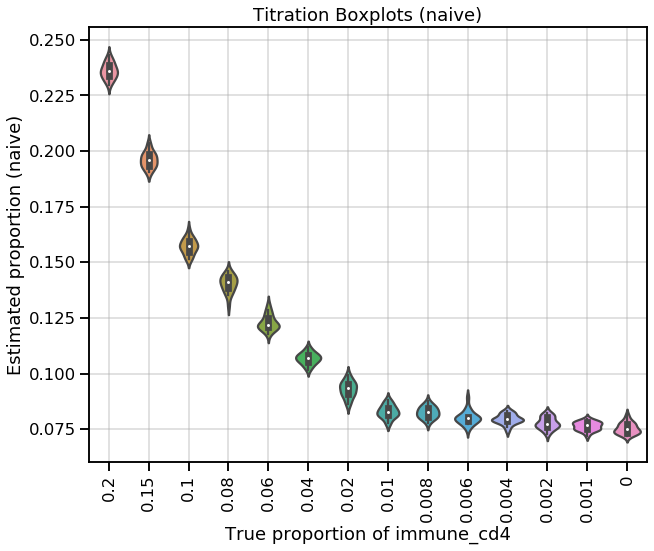

In [81]:
boxplot_titration(deconvolution_naive[cell_idx], CELLTYPE_ATLAS[cell_idx], TITRATION_LIST , 'naive')

In [82]:
# plot boxplots / violin plots

In [83]:
def boxplot_titration_zoom(list_of_deconvolution_dfs, cell_type, true_proportions, deconvolution_method_name):

    dfs = []
    plots = []

    # Get dataframe into scatter plot format
    for i in range(0, len(list_of_deconvolution_dfs)):
        df = list_of_deconvolution_dfs[i]
        phat = df[df.index == cell_type].values.squeeze()
        p_idx = np.repeat(true_proportions[i], len(phat))
        df = {'idx': p_idx, 'phat': phat}
        df = pd.DataFrame(df)
        df['idx'] = df['idx'].astype(str)
        dfs.append(df)

    # Calculate the grid size: square root of the number of dataframes
    grid_size = math.ceil(math.sqrt(len(dfs)))

    # Create a figure with a grid of subplots
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    # Flatten the axs array for easy iterating
    axs = axs.ravel()

    # Create a boxplot on each subplot using your data
    for i, df in enumerate(dfs):
        sns.violinplot(data=df, x="idx", y="phat", ax=axs[i], zorder=2)
        plot_name = true_proportions[i]
        axs[i].set_xlabel('') 
        axs[i].set_ylabel('') 

    # If there are more subplots than dataframes, remove the extras
    if len(dfs) < len(axs):
        for i in range(len(dfs), len(axs)):
            fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

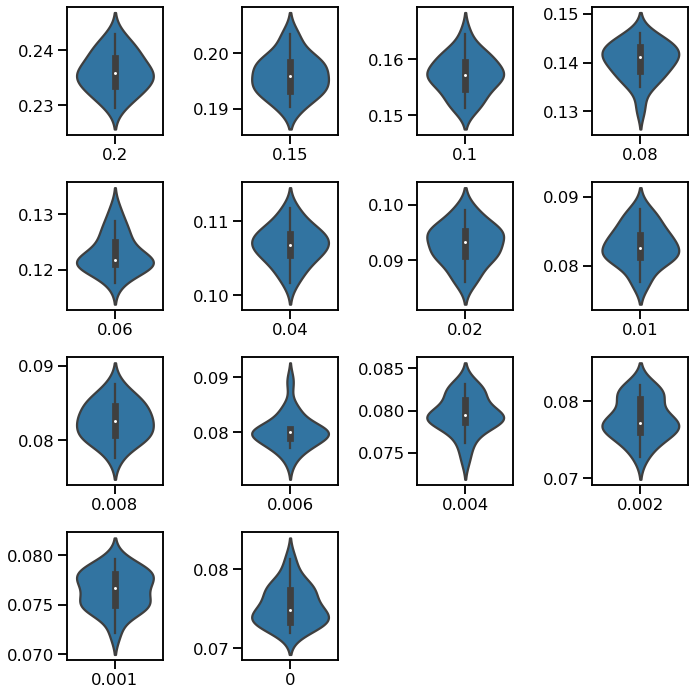

In [84]:
boxplot_titration_zoom(deconvolution_naive[cell_idx], CELLTYPE_ATLAS[cell_idx], TITRATION_LIST , 'naive')

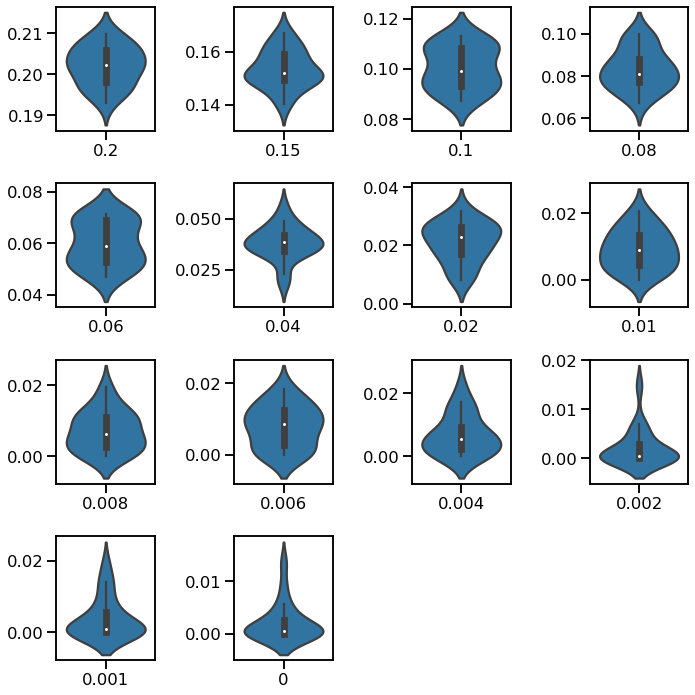

In [85]:
boxplot_titration_zoom(deconvolution_nnls[cell_idx], CELLTYPE_ATLAS[cell_idx], TITRATION_LIST , 'nnls')

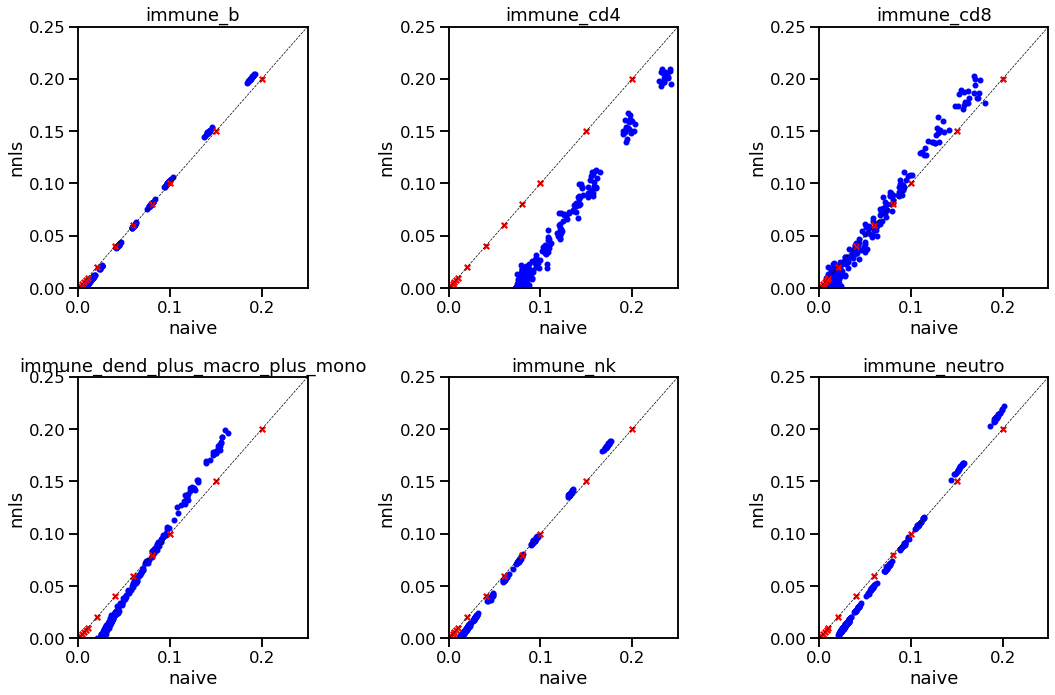

In [86]:
# def scatter_nnls_naive(celltype, celltype_atlas, n_titration):
    
#     preds_nnls = np.array([])
#     preds_naive = np.array([])
    
#     celltype_idx = celltype_atlas.index(celltype)
    
#     for i in range(0, n_titration):
        
#         df_nnls = deconvolution_nnls[celltype_idx][i]
#         pred_nnls =  df_nnls[df_nnls.index == celltype].values.squeeze()
#         preds_nnls = np.concatenate([preds_nnls, pred_nnls])

#         df_naive = deconvolution_naive[celltype_idx][i]
#         pred_naive =  df_naive[df_naive.index == celltype].values.squeeze()
#         preds_naive = np.concatenate([preds_naive, pred_naive])
    
#     preds_nnls = preds_nnls.squeeze()
#     preds_naive = preds_naive.squeeze()
    
#     # plot
#     x = np.linspace(0,100,101) 

#     plt.plot(x,x,'--', color='black', linewidth=0.7) # identity line

#     plt.xlim(0,1)
#     plt.ylim(0,1)
    
#     plt.scatter(preds_naive, preds_nnls, s=30)
#     plt.xlabel('naive estimates')
#     plt.ylabel('nnls estimates')
#     plt.title(f'{celltype}')

                                    
# CELLTYPE = 'immune_b'
# N_TITRATION = len(TITRATION_LIST)
# scatter_nnls_naive(celltype=CELLTYPE, celltype_atlas=CELLTYPE_ATLAS, n_titration = N_TITRATION)

def scatter_plot(ax, x, y, color, s, title, marks, xylimit=0.25):
    ax.scatter(x=x, y=y, c=color, s=s)
    ax.set_xlabel('naive')
    ax.set_ylabel('nnls')
    ax.set_xlim(0,xylimit)
    ax.set_ylim(0,xylimit)
    ax.set_title(title)
    
    x = np.linspace(0,100,101) 
    ax.plot(x,x,'--', color='black', linewidth=0.7) # identity line
    
    # Marking the coordinates with a red "X"
    for mark in marks:
        if mark <= xylimit: # Making sure the mark is within the limits of the plot
            ax.scatter(mark, mark, c='red', marker='x', s=30)


    
def scatter_nnls_naive(celltype_atlas, n_titration):
    
    k = 0
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
    for i in range(2):
        for j in range(3):

            celltype = celltype_atlas[k]

            preds_nnls = np.array([])
            preds_naive = np.array([])

            celltype_idx = celltype_atlas.index(celltype)

            for z in range(0, n_titration):

                df_nnls = deconvolution_nnls[celltype_idx][z]
                pred_nnls =  df_nnls[df_nnls.index == celltype].values.squeeze()
                preds_nnls = np.concatenate([preds_nnls, pred_nnls])

                df_naive = deconvolution_naive[celltype_idx][z]
                pred_naive =  df_naive[df_naive.index == celltype].values.squeeze()
                preds_naive = np.concatenate([preds_naive, pred_naive])

            preds_nnls = preds_nnls.squeeze()
            preds_naive = preds_naive.squeeze()

            # plot

            scatter_plot(ax=axs[i, j],x=preds_naive, y=preds_nnls, color='blue', s=20, title=f'{celltype}', xylimit=0.25, marks=TITRATION_LIST)


#             plt.xlabel('naive estimates')
#             plt.ylabel('nnls estimates')
#             plt.title(f'{celltype}')

            k +=1
    
    plt.tight_layout()
    plt.show()

N_TITRATION = len(TITRATION_LIST)
scatter_nnls_naive(CELLTYPE_ATLAS, N_TITRATION)

In [87]:
CELLTYPE_ATLAS

['immune_b',
 'immune_cd4',
 'immune_cd8',
 'immune_dend_plus_macro_plus_mono',
 'immune_nk',
 'immune_neutro']

0.019285714285714288


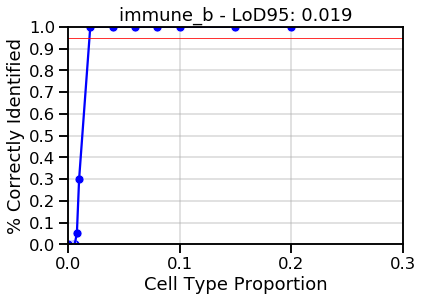

In [88]:

CELL_TYPE = 'immune_b'
TRUE_PROPORTIONS = TITRATION_LIST
celltype_idx = CELLTYPE_ATLAS.index(CELL_TYPE)

testing = deconvolution_naive[celltype_idx]

###### ----- correct proportion
# detect with close to true proportion
EPS = TITRATION_LIST

p_correct = []

testing = deconvolution_naive[celltype_idx]

for i in range(0,len(testing)):
    df = testing[i]
    m, n = df.shape
    eps = EPS[i] * 0.5
    true_p = TRUE_PROPORTIONS[i]
    true_p_min = true_p - eps 
    true_p_max = true_p + eps
    phat = df[df.index == CELL_TYPE]
    phat = phat.values.squeeze()
    phat_boolean = [(true_p_min <= x <= true_p_max) for x in phat]
    p_correct.append(sum(phat_boolean) / n)

p_correct


###### ----- plotting

# Replace these with your data
x_values = TRUE_PROPORTIONS
y_values = p_correct  #  p_correct #

# Sorting the x_values and y_values in the order of x_values
sorted_indices = np.argsort(x_values)
x_values_sorted = np.array(x_values)[sorted_indices]
y_values_sorted = np.array(y_values)[sorted_indices]

# Interpolating to find the x-value
y_target = 0.95
x_target = np.interp(y_target, y_values_sorted, x_values_sorted)
print(x_target)

# Create a scatter plot
sns.scatterplot(x=x_values, y=y_values, color='b')

# Create a line plot
sns.lineplot(x=x_values, y=y_values, color='b')

# Set the limits and spacing of the x and y axes
plt.xticks(ticks=[i/10 for i in range(11)])
plt.yticks(ticks=[i/10 for i in range(11)])
plt.xlim(0, 0.3)
plt.ylim(0, 1)


# Drawing horizontal and vertical lines
plt.axhline(y=y_target, xmin=0, xmax=x_target+1, color='r', linestyle='-', linewidth=0.8)
# plt.axvline(x=x_target, ymin=0, ymax=y_target, color='r', linestyle='-', linewidth=0.8)

plt.grid(True, alpha=0.5)
plt.gca().set_axisbelow(True)

plt.xlabel('Cell Type Proportion')
plt.ylabel('% Correctly Identified')
plt.title(f'{CELL_TYPE} - LoD95: ' + str(round(x_target,3)))

plt.show()

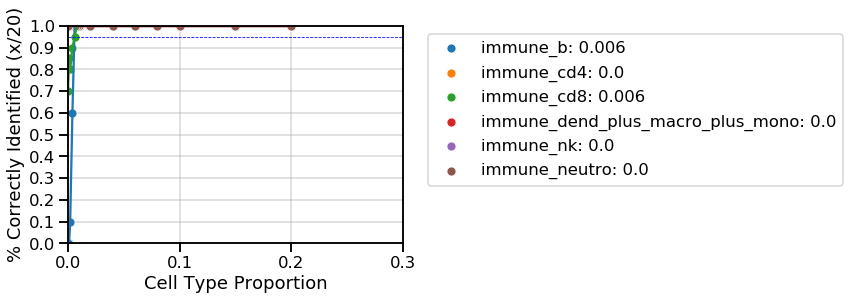

In [89]:


# remove t-cell: titration list, cell atlas, deconvolution_nnls/naive

# TITRATION_LIST = TITRATION_LIST[2:]
CELLTYPE_ATLAS_ = CELLTYPE_ATLAS#[2:]
deconvolution_naive_ = deconvolution_naive#[2:]
deconvolution_nnls_ = deconvolution_nnls#[2:]


TRUE_PROPORTIONS = TITRATION_LIST


data = []
lod95_value = []

# <- start loop
for celltype in CELLTYPE_ATLAS_:
    
    CELL_TYPE = celltype

    celltype_idx = CELLTYPE_ATLAS_.index(CELL_TYPE)
    testing = deconvolution_naive_[celltype_idx]

    ###### ----- correct proportion
    # detect with close to true proportion
    EPS = TITRATION_LIST

    p_correct = []

    testing = deconvolution_naive_[celltype_idx]

    # for i in range(0,len(testing)):
    #     df = testing[i]
    #     m, n = df.shape
    #     eps = EPS[i] * 0.5
    #     true_p = TRUE_PROPORTIONS[i]
    #     true_p_min = true_p - eps 
    #     true_p_max = true_p + eps
    #     phat = df[df.index == CELL_TYPE]
    #     phat = phat.values.squeeze()
    #     phat_boolean = [(true_p_min <= x <= true_p_max) for x in phat]
    #     p_correct.append(sum(phat_boolean) / n)


    DETECTION_THRESHOLD = 0.01

    p_detect = []

    for df in testing:
        m, n = df.shape
        phat = df[df.index == CELL_TYPE]
        phat_boolean = phat > DETECTION_THRESHOLD
        p_detected = sum(phat_boolean.values.squeeze()) / n
        p_detect.append(p_detected)

    p_correct = p_detect


    ###### ----- plotting

    # Replace these with your data
    x_values = TRUE_PROPORTIONS
    y_values = p_correct  #  p_correct #
    
    data.append((x_values, y_values))

    # Sorting the x_values and y_values in the order of x_values
    sorted_indices = np.argsort(x_values)
    x_values_sorted = np.array(x_values)[sorted_indices]
    y_values_sorted = np.array(y_values)[sorted_indices]

    # Interpolating to find the x-value
    y_target = 0.95
    x_target = np.interp(y_target, y_values_sorted, x_values_sorted)
    lod95_value.append(x_target)



for i, (x_values, y_values) in enumerate(data):
    name = CELLTYPE_ATLAS_[i]
    lod95 = round(lod95_value[i], 3)
    label = f'{name}: {lod95}'
    sns.scatterplot(x=x_values, y=y_values, label=label)
    sns.lineplot(x=x_values, y=y_values)

# Set the limits and spacing of the x and y axes
plt.xticks(ticks=[i/10 for i in range(11)])
plt.yticks(ticks=[i/10 for i in range(11)])
plt.xlim(0, 0.3)
plt.ylim(0, 1)

plt.axhline(y=y_target, xmin=0, xmax=x_target+1, color='blue', linestyle='--', linewidth=0.8)

plt.grid(True, alpha=0.5)
plt.gca().set_axisbelow(True)

plt.xlabel('Cell Type Proportion')
plt.ylabel('% Correctly Identified (x/20)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

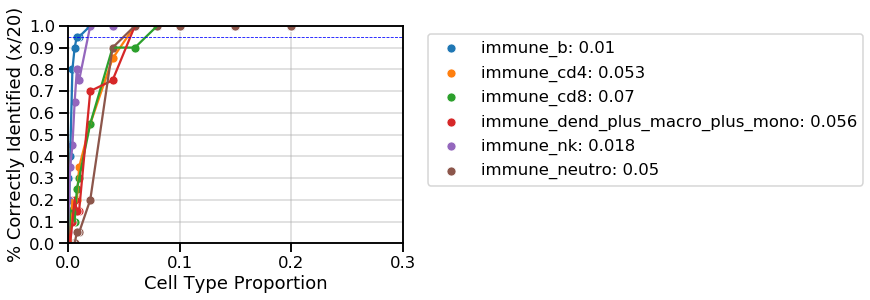

In [91]:

data = []
lod95_value = []

# <- start loop
for celltype in CELLTYPE_ATLAS_:
    
    CELL_TYPE = celltype

    celltype_idx = CELLTYPE_ATLAS_.index(CELL_TYPE)
    testing = deconvolution_nnls_[celltype_idx]

    ###### ----- correct proportion
    # detect with close to true proportion
    EPS = TITRATION_LIST

    p_correct = []

    testing = deconvolution_nnls_[celltype_idx]

    for i in range(0,len(testing)):
        df = testing[i]
        m, n = df.shape
        eps = EPS[i] * 0.3
        true_p = TRUE_PROPORTIONS[i]
        true_p_min = true_p - eps 
        true_p_max = true_p + eps
        phat = df[df.index == CELL_TYPE]
        phat = phat.values.squeeze()
        phat_boolean = [(true_p_min <= x <= true_p_max) for x in phat]
        p_correct.append(sum(phat_boolean) / n)


#     DETECTION_THRESHOLD = 0.01

#     p_detect = []

#     for df in testing:
#         m, n = df.shape
#         phat = df[df.index == CELL_TYPE]
#         phat_boolean = phat > DETECTION_THRESHOLD
#         p_detected = sum(phat_boolean.values.squeeze()) / n
#         p_detect.append(p_detected)

#     p_correct = p_detect


    ###### ----- plotting

    # Replace these with your data
    x_values = TRUE_PROPORTIONS
    y_values = p_correct  #  p_correct #
    
    data.append((x_values, y_values))

    # Sorting the x_values and y_values in the order of x_values
    sorted_indices = np.argsort(x_values)
    x_values_sorted = np.array(x_values)[sorted_indices]
    y_values_sorted = np.array(y_values)[sorted_indices]

    # Interpolating to find the x-value
    y_target = 0.95
    x_target = np.interp(y_target, y_values_sorted, x_values_sorted)
    lod95_value.append(x_target)



for i, (x_values, y_values) in enumerate(data):
    name = CELLTYPE_ATLAS_[i]
    lod95 = round(lod95_value[i], 3)
    label = f'{name}: {lod95}'
    sns.scatterplot(x=x_values, y=y_values, label=label)
    sns.lineplot(x=x_values, y=y_values)

# Set the limits and spacing of the x and y axes
plt.xticks(ticks=[i/10 for i in range(11)])
plt.yticks(ticks=[i/10 for i in range(11)])
plt.xlim(0, 0.3)
plt.ylim(0, 1)

plt.axhline(y=y_target, xmin=0, xmax=x_target+1, color='blue', linestyle='--', linewidth=0.8)

plt.grid(True, alpha=0.5)
plt.gca().set_axisbelow(True)

plt.xlabel('Cell Type Proportion')
plt.ylabel('% Correctly Identified (x/20)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()